In [1]:
%matplotlib inline

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F


import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.optim as optim
import cv2

# from LFWDataset import LFWDataset
# from SiameseNet import SiameseNet

In [2]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
class LFWDataset(Dataset):
    
    """Faces in the wild dataset."""

    def __init__(self, root_dir='lfw/', train=False, test=False, transform=None):
        self.train = train
        self.test = test
        self.root_dir = root_dir
        self.files = []
        self.labels = []
        self.transform = transform
        
        if (self.train and self.test) or not (self.train or self.test):
            raise ValueError('Exactly one of train and test must be set.')
        
        """
        Getting Train/Test splits
        """
        dataset = set()
        if self.train:
            filename='train.txt'
        else:
            filename='test.txt'

        with open(filename) as f:
            for line in f:
                line = line.split()
                self.files.append(line[:2])
                self.labels.append(int(line[2]))
                
        #print(self.files)
    
    def __len__(self):
        return len(self.files)
#         return sum([len(files) for r, d, files in os.walk(self.root_dir)])
#         https://stackoverflow.com/questions/16910330/return-number-of-files-in-directory-and-subdirectory

    def __getitem__(self, idx):
        im_names = self.files[idx]
        im1 = Image.open(os.path.join(self.root_dir, im_names[0]))
        im2 = Image.open(os.path.join(self.root_dir, im_names[1]))
        label = self.labels[idx]
        
        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
            
        return im1, im2, label

In [3]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class SiameseNet(nn.Module):

    def __init__(self):
        super(SiameseNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 5, stride=(1,1), padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2,2), stride=(2,2)),
            
            nn.Conv2d(64, 128, 5, stride=(1,1), padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((2,2), stride=(2,2)),
            
            nn.Conv2d(128, 256, 3, stride=(1,1), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d((2,2), stride=(2,2)),
            
            nn.Conv2d(256, 512, 3, stride=(1,1), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 16 * 16, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(2*1024, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        output = self.cnn(x)
        #flatten
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output        

    def forward(self, input1, input2):
        f1 = self.forward_once(input1)
        f2 = self.forward_once(input2)
#         print(f1, f2)
        output = self.fc2(torch.cat((f1, f2), 1))
        return output


In [4]:
%matplotlib inline
def show(img, filename=None, save=False):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()
    if save and filename is not None:
        plt.savefig(filename)

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

In [5]:
trainset = LFWDataset(train=True,
                      transform=transforms.Compose([transforms.Scale((128,128)),
                                                                      transforms.ToTensor()
                                                                      ]))
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)




In [6]:
# vis_dataloader = DataLoader(trainset,
#                         shuffle=True,
#                         num_workers=8,
#                         batch_size=8)
# dataiter = iter(vis_dataloader)

# example_batch = next(dataiter)
# concatenated = torch.cat((example_batch[0],example_batch[1]),0)

# show(torchvision.utils.make_grid(concatenated))
# print(example_batch[2].numpy())

In [7]:
net = SiameseNet().cuda()
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-6
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [8]:
print(net)

SiameseNet (
  (cnn): Sequential (
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU (inplace)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU (inplace)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (7): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (11): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  )
  (fc1): Sequential (
    (0): Linear (131072 -> 1024)
    (1): ReLU (inplace)
    (2): BatchNorm2d(1024, 

In [26]:
counter = []
loss_history = [] 
iteration_number= 0
epochs = 50

In [44]:
for epoch in range(epochs):
    for i, data in enumerate(trainloader,0):

        img0, img1, label = data 
        if i < 1:
            concat = torch.cat((img0, img1), 0)
            grid = torchvision.utils.make_grid(concat, nrow=2)
            im = transforms.ToPILImage()(grid)
            im.save("output.png")
            print(label)
            
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        
        output = net(img0,img1)
        output = torch.cat((output, 1-output), 1)
        #output is of the form [similarity, 1-similarity]
        #closer to [1, 0] is same face, [0, 1] is different face.
                
        optimizer.zero_grad()
        loss = criterion.forward(output, label)
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss.data[0]))
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss.data[0])
            


 1
 0
 0
 1
 1
 1
 0
 1
 1
 1
 0
 1
 1
 1
 1
 0
 1
 1
 1
 1
 1
 0
 0
 0
 0
 1
 1
 1
 0
 0
 1
 1
 0
 1
 1
 1
 0
 1
 1
 1
 1
 0
 1
 1
 0
 1
 1
 0
 0
 0
 0
 1
 0
 1
 1
 0
 1
 1
 1
 0
 1
 0
 1
 1
[torch.LongTensor of size 64]



Process Process-67:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zdavidli/.local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
    return recv()
Process Process-68:
  File "/home/zdavidli/.local/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
    buf = self.recv_bytes()
KeyboardInterrupt
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zdavidli/.local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
KeyboardInterrupt


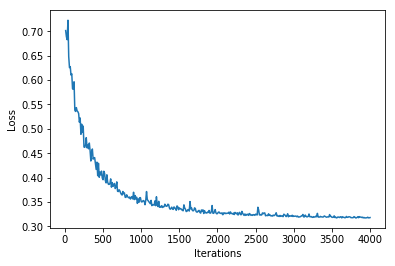

In [75]:
show_plot(counter,loss_history)

In [76]:
torch.save(net.state_dict(), "model")

In [9]:
testset = LFWDataset(test=True,
                     transform=transforms.Compose([transforms.Scale((128, 128)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

In [10]:
testnet = SiameseNet().cuda()
testnet.load_state_dict(torch.load("model"))

In [13]:
right=wrong=0

for i, data in enumerate(trainloader,0):
    im1, im2, label = data
    label = label[0]
#     concatenated = torch.cat((im1,im2),0)
    
    output = testnet(Variable(im1).cuda(),Variable(im2).cuda())
    
    for el in output:
        if el.data[0] > 0.5:
            #predict same face
            if label == 1:
                right += 1
            else:
                wrong += 1
        else:
            #predict different
            if label == 0:
                right += 1
            else:
                wrong += 1

In [14]:
print(right, wrong, right+wrong)

(1062, 1138, 2200)


In [84]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive